# U.S. Medical Insurance Costs

We have a csv file `insurance_data.csv`, which contains insurance costs and several related datapoints. Here, we do a series of linear regression to find the effect of each variable on the final cost.

## Data Parsing
We have a csv file with insurance costs in the U.S., containing age, bmi, sex, number of children, smoker status, and geographical region. The following blocks of code load the data and saves it to relevant variables. 

`insurance_data` contains all of the csv data as a dictionary, with the key being the id (row index).
`ages`, `bmis`, `sexes`, `children_nums`, `smokers`, `regions`, and `costs` are all Numpy arrays containing the related data in the same order.

In [1]:
import csv
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
insurance_data = {}

with open('insurance.csv') as insurance_csv:
    insurance_dict_reader = csv.DictReader(insurance_csv)
    for i, row in enumerate(insurance_dict_reader):
        insurance_data[i] = row  # The row number becomes the id.

print(f'Index 0 data: {insurance_data[0]}')
print(f'There are {len(insurance_data.keys())} datapoints in this dataset')

Index 0 data: {'age': '19', 'sex': 'female', 'bmi': '27.9', 'children': '0', 'smoker': 'yes', 'region': 'southwest', 'charges': '16884.924'}
There are 1338 datapoints in this dataset


`smoker`, `sex`, and `region` are all strings in the csv file. We will use a lookup table to convert these string values to floats for analysis.

In [3]:
# Lookup tables for string values
smoker_dict = {'yes': 1, 'no': 0}
sexes_dict = {'female': 1, 'male': 0}
regions_dict = {'northwest': 0, 'northeast': 1, 'southeast': 2, 'southwest': 3}

In [4]:
# Initialize the data variables as empty lists.
ages = []
bmis = []
sexes = []
children_nums = []
smokers = []
regions = []
costs = []

# Add the data to each list.
for idx in range(len(insurance_data.keys())):
    ages.append(insurance_data[idx]['age'])
    bmis.append(insurance_data[idx]['bmi'])
    sexes.append(sexes_dict[insurance_data[idx]['sex']])
    children_nums.append(insurance_data[idx]['children'])
    smokers.append(smoker_dict[insurance_data[idx]['smoker']])
    regions.append(regions_dict[insurance_data[idx]['region']])
    costs.append(insurance_data[idx]['charges'])
    
# Convert data variables to Numpy arrays.
ages = np.array(ages, dtype=float)
bmis = np.array(bmis, dtype=float)
sexes = np.array(sexes, dtype=float)
children_nums = np.array(children_nums, dtype=float)
smokers = np.array(smokers, dtype=float)
regions = np.array(regions, dtype=float)
costs = np.array(costs, dtype=float)

print(f'First 10 ages: {ages[:10]}')

First 10 ages: [19. 18. 28. 33. 32. 31. 46. 37. 37. 60.]


Because `smoker` can be one of four discrete categories, the float is not as useful to us. We'll convert it to four different variables with one-hot encoding.

In [5]:
regions_one_hot = np.array((
    np.where(regions == 0, 1., 0.),
    np.where(regions == 1, 1., 0.),
    np.where(regions == 2, 1., 0.),
    np.where(regions == 3, 1., 0.),
))

## Linear Regression

In [6]:
def get_y(m, b, x):
    return m * x + b

In [7]:
def get_error(m, b, points):
    points_x = points[:, 0]
    points_y = points[:, 1]
    return np.abs(points_y - get_y(m, b, points_x))

`linear_regression` takes array-likes of ms, bs, and points, and tests all of the possible ms and bs. It will return the `m` and `b` that return the smallest error for `y = mx + b`.

In [8]:
def linear_regression(ms, bs, points):
    m_best = 0
    b_best = 0
    error = float('inf')
    for m in ms:
        for b in bs:
            if error < get_error(m, b, points).mean():
                continue
            error = get_error(m, b, points).mean()
            m_best = m
            b_best = b
    return m_best, b_best

`get_range_array` will return a range centered on `center` with a spread of +/- `tolerance_percent`%. There is also a safeguard if center is close to zero.

In [9]:
def get_range_array(center, tolerance_percent=0.1, steps=100):
    if abs(center) > 10:
        start = center * (1 - tolerance_percent)
        stop = center * (1 + tolerance_percent)
    else:
        start = center - tolerance_percent * steps / 2
        stop = center + tolerance_percent * steps / 2
    increment = (stop - start) / steps
    return np.arange(start, stop+increment, increment)

`run_linear_regression` will run a series of linear regressions to find the best fit. This algorithm balances testing a wide range and a small interval by doing the following:
1. Select an initial `m` and `b`.
2. Select an initial `tolerance` that is large.
3. Build a range of `ms` and `bs` centered around the current values with a spread related to the tolerance
4. Find the best `m` and `b` within that range.
5. If either `m` or `b` are at the edge of the range, recenter the ranges on the current values and continue with the same tolerance. 
6. Else, lower the tolerance.
7. Go to Step 3 and repeat until a sufficiently lower tolerance is met.

In [10]:
def run_linear_regressions(points, initial_m=250., initial_b=3000.):
    m_best = initial_m
    b_best = initial_b
    for tolerance in [1e1, 1e0, 1e-1, 1e-2, 1e-3]:
        m_range = get_range_array(m_best, tolerance)
        b_range = get_range_array(b_best, tolerance)
        m_best, b_best = linear_regression(m_range, b_range, points)
        
        # Recenter if any of values are at the edges
        move_counter = 0
        while m_best in [m_range.min(), m_range.max()] or b_best in [b_range.min(), b_range.max()]:
            m_range = get_range_array(m_best, tolerance)
            b_range = get_range_array(b_best, tolerance)
            m_best, b_best = linear_regression(m_range, b_range, points)
            move_counter += 1
            if move_counter > 100:  # To avoid the algorithm running indefinitely
                return None, None
    return m_best, b_best

While not directly used in linear regression, `get_unique_and_significant_values` returns bucketed variables of the unique values and significant values from several for a datapoint. "Significant" here is defined as being within 2 standard deviations. Useful for both filtering outliers and plotting data.

In [11]:
def get_unique_and_significant_values(values):
    values_unique = np.unique(values)
    # Values are significant if they are within 2 standard deviations
    mean, std = values.mean(), values.std()
    lower, upper = mean - 2 * std, mean + 2 * std
    values_significant = values_unique[np.where(np.logical_and(values_unique > lower, values_unique < upper))]
    return values_unique, values_significant

## Age Analysis

In [12]:
print(f'Average age: {ages.mean()}')

Average age: 39.20702541106129


In [13]:
# Find the unique ages, and then calculate the average cost per unique age
ages_unique, ages_significant = get_unique_and_significant_values(ages)
avg_cost_per_age = np.array([np.array(costs[ages==i], dtype=float).mean() for i in ages_significant])
ages_costs = np.stack([ages_significant, avg_cost_per_age], axis=-1)

In [14]:
m_age, b_age = run_linear_regressions(ages_costs, 10000, 3000)
print(m_age, b_age, get_error(m_age, b_age, ages_costs).mean())

253.46636682595246 3079.635454108041 1816.387347274485


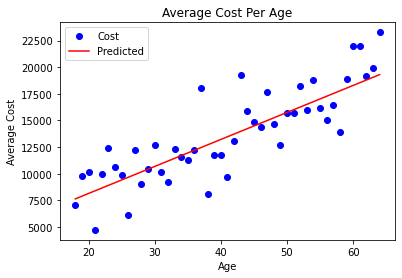

In [15]:
# From the linear regression, we got m=253.5 and b=3078.5. Here, we'll plot that
predicted_ys = get_y(m_age, b_age, ages_costs[:, 0])
plt.plot(ages_costs[:, 0], ages_costs[:, 1], 'bo', ages_costs[:, 0], predicted_ys, 'r-')
plt.xlabel('Age')
plt.ylabel('Average Cost')
plt.title('Average Cost Per Age')
plt.legend(['Cost', 'Predicted'])
plt.show()

## BMI Analysis

In [16]:
print(f'Average BMI: {bmis.mean()}')

Average BMI: 30.66339686098655


In [17]:
bmis_rounded = np.around(bmis)
bmis_unique, bmis_significant = get_unique_and_significant_values(bmis_rounded)
avg_cost_per_bmi = np.array([np.array(costs[bmis_rounded==i], dtype=float).mean() for i in bmis_significant])
bmis_costs = np.stack([bmis_significant, avg_cost_per_bmi], axis=-1)

In [18]:
m_bmi, b_bmi = run_linear_regressions(bmis_costs)
print(m_bmi, b_bmi, get_error(m_bmi, b_bmi, bmis_costs).mean())

441.00882000000144 110.46974447519982 1554.8338139479445


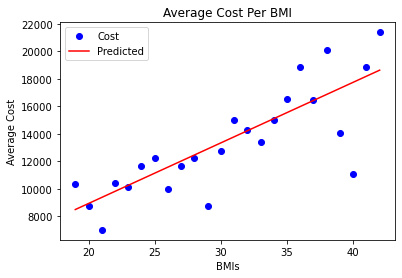

In [19]:
# Plot the results of the linear regression
predicted_ys = get_y(m_bmi, b_bmi, bmis_costs[:, 0])
plt.plot(bmis_costs[:, 0], bmis_costs[:, 1], 'bo', bmis_costs[:, 0], predicted_ys, 'r-')
plt.xlabel('BMIs')
plt.ylabel('Average Cost')
plt.title('Average Cost Per BMI')
plt.legend(['Cost', 'Predicted'])
plt.show()

## Children Analysis

In [20]:
print(f'Average number of children: {children_nums.mean()}')

Average number of children: 1.0949177877429


In [21]:
children_unique, children_significant = get_unique_and_significant_values(children_nums)
avg_cost_per_children = np.array([np.array(costs[children_nums==i], dtype=float).mean() 
                                  for i in children_significant])
children_costs = np.stack([children_significant, avg_cost_per_children], axis=-1)

In [22]:
m_children, b_children = run_linear_regressions(children_costs)
print(m_children, b_children, get_error(m_children, b_children, children_costs).mean())

996.4832147683242 12365.861669798367 336.50741802591847


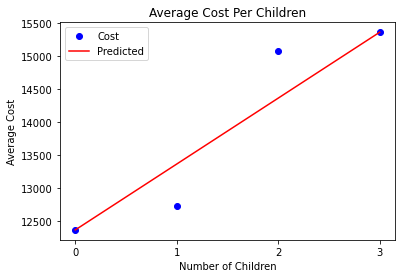

In [23]:
# Plot the results of the linear regression
predicted_ys = get_y(m_children, b_children, children_costs[:, 0])
plt.plot(children_costs[:, 0], children_costs[:, 1], 'bo', children_costs[:, 0], predicted_ys, 'r-')
plt.xlabel('Number of Children')
plt.xticks([0, 1, 2, 3])
plt.ylabel('Average Cost')
plt.title('Average Cost Per Children')
plt.legend(['Cost', 'Predicted'])
plt.show()

## Smoker Analysis

This is our first categorical value. Running the linear regressions on `smokers` wouldn't be useful since there are only two values to draw from: smoker and non-smoker. So, we simply take the difference in the mean cost between a smoker and non-smoker

In [24]:
print(f'Percentage of smokers in dataset: {smokers.mean()*100:0.1f}%')

Percentage of smokers in dataset: 20.5%


In [25]:
smoker_unique, smoker_significant = get_unique_and_significant_values(smokers)
avg_cost_per_smoker = np.array([np.array(costs[smokers==i], dtype=float).mean() 
                                  for i in smoker_significant])
smoker_costs = np.stack([smoker_significant, avg_cost_per_smoker], axis=-1)

In [26]:
m_smoker = smoker_costs[1, 1] - smoker_costs[0, 1]
print(m_smoker)

23615.963533676637


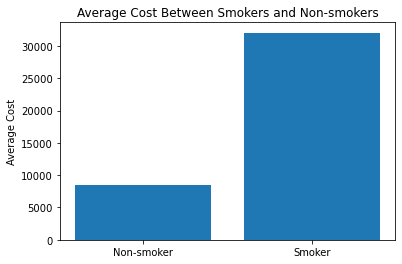

In [27]:
plt.bar(smoker_costs[:, 0], smoker_costs[:, 1], tick_label=['Non-smoker', 'Smoker'])
plt.ylabel("Average Cost")
plt.title("Average Cost Between Smokers and Non-smokers")
plt.show()

## Sex Analysis

We analyze this using the same method as smoker status. This dataset notably does not contain non-binary gender information.

In [28]:
print(f'Percentage of women in dataset: {sexes.mean()*100:0.1f}%')

Percentage of women in dataset: 49.5%


In [29]:
sex_unique, sex_significant = get_unique_and_significant_values(sexes)
avg_cost_per_sex = np.array([np.array(costs[sexes==i], dtype=float).mean() 
                                  for i in sex_significant])
sex_costs = np.stack([sex_significant, avg_cost_per_sex], axis=-1)

In [30]:
m_sex = sex_costs[1, 1] - sex_costs[0, 1]
print(m_sex)

-1387.1723338865468


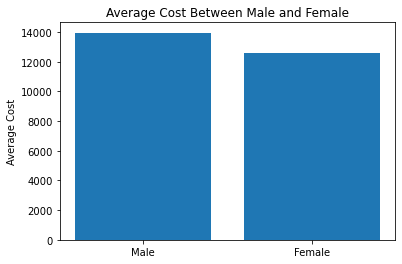

In [31]:
plt.bar(sex_costs[:, 0], sex_costs[:, 1], tick_label=['Male', 'Female'])
plt.ylabel("Average Cost")
plt.title("Average Cost Between Male and Female")
plt.show()

## Region Analysis

There are 4 different regions included: northwest, northeast, southeast, and southwest. From our one-hot encoding, we will take the difference between each and the average cost to find how each individual region affects the cost.

In [32]:
print(f'Percentage of each region in dataset:')
print(f'northwest: {(np.count_nonzero(regions_one_hot[0]) / len(regions) * 100):0.1f}%')
print(f'northeast: {(np.count_nonzero(regions_one_hot[1]) / len(regions) * 100):0.1f}%')
print(f'southeast: {(np.count_nonzero(regions_one_hot[2]) / len(regions) * 100):0.1f}%')
print(f'southwest: {(np.count_nonzero(regions_one_hot[3]) / len(regions) * 100):0.1f}%')

Percentage of each region in dataset:
northwest: 24.3%
northeast: 24.2%
southeast: 27.2%
southwest: 24.3%


In [33]:
region_unique, region_significant = get_unique_and_significant_values(regions)
avg_cost_per_region = np.array([np.array(costs[regions==i], dtype=float).mean() 
                                  for i in region_significant])
region_costs = np.stack([region_significant, avg_cost_per_region], axis=-1)

In [34]:
m_region = np.array([r_cost - costs.mean() for r_cost in region_costs[:, -1]])

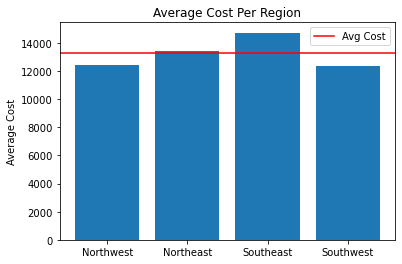

In [35]:
plt.bar(region_costs[:, 0], region_costs[:, 1], tick_label=['Northwest', 'Northeast', 'Southeast', 'Southwest'])
plt.axhline(costs.mean(), color='r', label='Avg Cost')
plt.ylabel("Average Cost")
plt.title("Average Cost Per Region")
plt.legend()
plt.show()

## All Analysis
Since we have now calculated the analysis with each individual variable, we'll combine the relevant ms and find the mean error.

In [36]:
print(m_age, m_bmi, m_children, m_smoker, m_sex, m_region)

253.46636682595246 441.00882000000144 996.4832147683242 23615.963533676637 -1387.1723338865468 [-852.84689117  135.96225124 1464.98917247 -923.48488785]


In [37]:
variables_combined = np.stack([ages, bmis, children_nums, smokers, sexes])
ms_all = np.stack([m_age, m_bmi, m_children, m_smoker, m_sex])

# Since region is one-hot encoded
variables_combined = np.concatenate([variables_combined, regions_one_hot])
ms_all = np.concatenate([ms_all, m_region])
costs_calculated_no_bias = get_y(ms_all[:, None], 0., variables_combined).sum(axis=0)

To find the bias, we run the linear regression using all of the variables and calculated weights from before. Since some of the bias could be included in the other variables, we also calculate an `m` to multiply by all of the `ms`

In [38]:
m_all, b_all = run_linear_regressions(
    np.stack([costs_calculated_no_bias, costs], axis=-1), 
    initial_m=1., 
    initial_b=-15000.
)

In [39]:
m_all, b_all

(0.8110000000000149, -11770.123794521072)

In [40]:
linear_error = get_error(m_all, b_all, np.stack([costs_calculated_no_bias, costs], axis=-1)).mean()
print(f'Average error: ${linear_error:.2f}')

Average error: $4477.48


The average error found by combining the individual simple linear regressions is $4477.48. While this gives a somewhat reasonable error, it treats each of the variables as completely independent, which is not the case. `bmi` and `region` are correlated, as well as `age` and `children_num`. For this reason, we must perform a multiple linear regression to get the true weight of each variable.

## Multiple Linear Regression

We must first create the functions to perform gradient descent. This uses a loss function of MSE. The dataset is small enough that we can perform gradient descent across the whole dataset without splitting into minibatches.

In [41]:
def get_loss(y_true, y_pred):
    return (y_pred - y_true) ** 2

In [42]:
def cost_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true)

In [43]:
def weight_derivative(value):
    return value

In [44]:
def bias_derivative():
    return 1

In [45]:
def get_ys(values, weights, bias):
    return get_y(weights[:, None], 0, values).sum(axis=0) + bias

In [46]:
def get_errors(values, correct, weights, bias):
    pred = get_y(weights[:, None], 0, values).sum(axis=0) + bias 
    return np.abs(pred - correct)

For the equation:
$$
    y = w_1x_1 + w_2x_2 + \cdots + w_nx_n + b,
$$
and a loss (or cost $C$) of MSE:
$$
    C = (y_{pred} - y_{true}) ^ 2,
$$
the gradient vector can be calculated by taking the derivative of the loss with respect to each of the weights and biases.
For each of the weights, by the chain rule,
$$
    \frac{\delta C}{\delta w_n}=\frac{\delta C}{\delta y} \times \frac{\delta y}{\delta w_n} = 2 (y_{pred} - y_{true}) \times x_n,
$$
with the bias being simply
$$
    \frac{\delta C}{\delta b}=\frac{\delta C}{\delta y} \times \frac{\delta y}{\delta b} = 2 (y_{pred} - y_{true}) \times 1.
$$
So the final gradient vector would be:
$$
    \nabla C = \begin{bmatrix} 
        2 (y_{pred} - y_{true}) x_1 && 2 (y_{pred} - y_{true}) x_2 && \cdots && 2 (y_{pred} - y_{true})
    \end{bmatrix}
$$

In [47]:
def get_gradient_vector(values, weights, bias, y_true, y_pred):
    dw = weight_derivative(values) * cost_derivative(y_true, y_pred)
    db = bias_derivative() * cost_derivative(y_true, y_pred)
    gradient_vector = np.concatenate([dw, [db]], axis=0)
    return gradient_vector.mean(axis=-1)

`run_multiple_regressions` runs a regression for `iterations`, changing the weights and biases by the calculated gradient vector. It starts with an initial `learning_rate` that is decayed by `lr_decay` on each iteration.

In [48]:
def run_multiple_regressions(inputs, costs, iterations=100000, learning_rate=1e-4, lr_decay=0.999995):
    # Initialize all ms to be the calculated values from before and b as b_all
    weights = np.stack([m_age, m_bmi, m_children, m_smoker, m_sex])
    weights = np.concatenate([weights, m_region])
    bias = np.array([b_all])
    weights_and_biases = np.concatenate([weights, bias])
    losses = []
    y_pred = get_ys(inputs, weights_and_biases[:-1], weights_and_biases[-1])
    for iteration in tqdm(range(iterations)):
        y_pred = get_ys(inputs, weights_and_biases[:-1], weights_and_biases[-1])
        loss = get_loss(costs, y_pred).mean()
        gv = get_gradient_vector(inputs, weights_and_biases[:-1], weights_and_biases[-1], costs, y_pred)
        weights_and_biases -= gv * learning_rate
        losses.append(loss)
        learning_rate *= lr_decay
    return losses, weights_and_biases

In [49]:
variables_combined = np.stack([ages, bmis, children_nums, smokers, sexes], axis=0)
variables_combined = np.concatenate([variables_combined, regions_one_hot], axis=0)
losses, wb = run_multiple_regressions(variables_combined, costs, iterations=1000000, learning_rate=1e-4)
multiple_error = get_errors(variables_combined, costs, wb[:-1], wb[-1]).mean()
print(f'Average error: ${multiple_error:.2f}')

  0%|          | 0/1000000 [00:00<?, ?it/s]

Average error: $4163.11


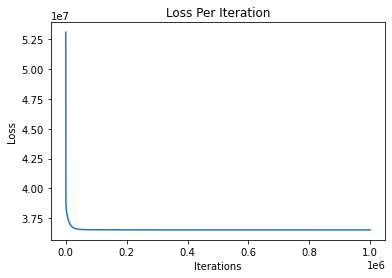

In [50]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.xticks(np.arange(0, 1000001, 200000))
plt.ylabel('Loss')
plt.title('Loss Per Iteration')
plt.show()

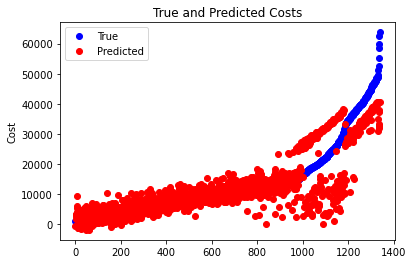

In [51]:
data = np.concatenate([variables_combined, [costs]], axis=0)
data_sorted = data[:, np.argsort(data, axis=-1)[-1]]
yp_sorted = get_ys(data_sorted[:-1], wb[:-1], wb[-1])
plt.plot(np.arange(len(costs)), data_sorted[-1], 'bo', np.arange(len(costs)), yp_sorted, 'ro')
plt.ylabel('Cost')
plt.title('True and Predicted Costs')
plt.legend(['True', 'Predicted'])
plt.show()

This error of \\$4163.11 is significantly better than our error from before of \\$4477.48, but there are outliers near the higher end. We will now filter out any values more than 2 standard deviations from the mean.

In [52]:
print(f'Cost mean, std: {costs.mean()}, {costs.std()}')
mean = costs.mean()
std = costs.std()
lower, upper = mean - 2 * std, mean + 2 * std

Cost mean, std: 13270.422265141257, 12105.484975561612


In [53]:
valid_indices = np.where(np.logical_and(data[-1] < upper, data[-1] > lower))
data_valid = data[:, np.array(valid_indices[-1])]

In [54]:
losses_valid, wb_valid = run_multiple_regressions(data_valid[:-1], data_valid[-1], iterations=1000000, 
                                                  learning_rate=1e-4)
filtered_error = get_errors(data_valid[:-1], data_valid[-1], wb_valid[:-1], wb_valid[-1]).mean()
print(f'Average error: ${filtered_error:.2f}')

  0%|          | 0/1000000 [00:00<?, ?it/s]

Average error: $3130.46


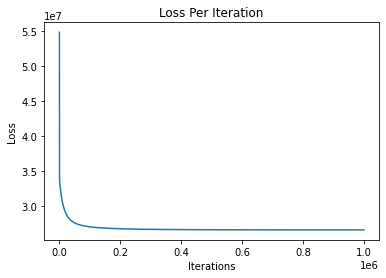

In [55]:
plt.plot(losses_valid)
plt.xlabel('Iterations')
plt.xticks(np.arange(0, 1000001, 200000))
plt.ylabel('Loss')
plt.title('Loss Per Iteration')
plt.show()

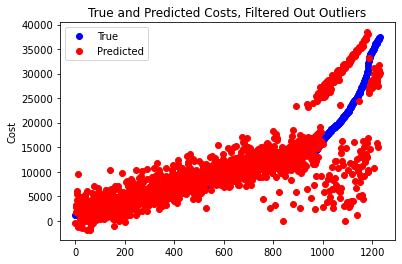

In [56]:
data_valid_sorted = data_valid[:, np.argsort(data_valid, axis=-1)[-1]]
yp_valid_sorted = get_ys(data_valid_sorted[:-1], wb[:-1], wb[-1])

plt.plot(np.arange(len(data_valid_sorted[-1])), data_valid_sorted[-1], 'bo', 
         np.arange(len(data_valid_sorted[-1])), yp_valid_sorted, 'ro')
plt.ylabel('Cost')
plt.title('True and Predicted Costs, Filtered Out Outliers')
plt.legend(['True', 'Predicted'])
plt.show()

This is significantly better with an average error of \\$3130.46! Here is a table of our results:

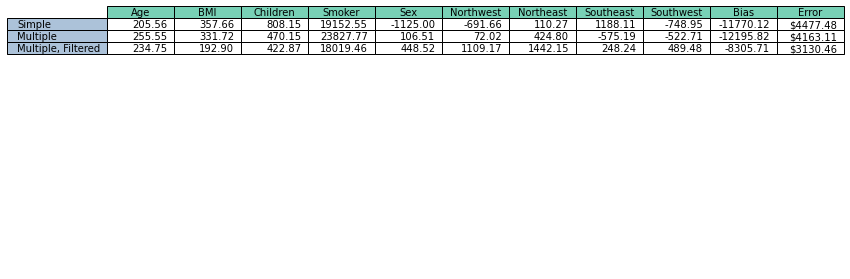

In [57]:
table_cols = ['Age', 'BMI', 'Children', 'Smoker', 'Sex', 'Northwest', 'Northeast', 'Southeast', 
              'Southwest', 'Bias', 'Error']
table_rows = ['Simple', 'Multiple', 'Multiple, Filtered']
table_cells = [
    [f'{w:.2f}' for w in (ms_all * m_all)] + [f'{b_all:.2f}', f'${linear_error:.2f}'],
    [f'{w:.2f}' for w in wb] + [f'${multiple_error:.2f}'],
    [f'{w:.2f}' for w in wb_valid] + [f'${filtered_error:.2f}']
]

plt.axis('off')
plt.table(cellText=table_cells, rowLabels=table_rows, colLabels=table_cols, loc='top', 
          colWidths=[0.2 for _ in table_cols], colColours=['xkcd:seafoam blue' for _ in table_cols],
          rowColours=['xkcd:cloudy blue' for _ in table_rows]
  )
plt.show()

We found a final error of \\$3130.46. This is really good, especially around the lower costs. From the graphs, we can see that the error is large for higher costs. This could be due to variables not accounted for in the data, such as previous medical history. For such a small dataset of only 1338, doing any more custom fitting would simply result in an overfit model.